In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore') 

# Load the dataset
file_path = "C:\\Users\\Think\\Desktop\\IS403\\Final\\Dataset\\June1st\\CTG.VN-BaoCao.csv" 
data = pd.read_csv(file_path)
data.dropna(inplace=True)

# Parse the Date column and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Create lag features for the 'Close' price
def create_lag_features(df, lags):
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['Close'].shift(lag)
    df = df.dropna()
    return df

# Calculate Exponential Moving Average (EMA)
def calculate_ema(df, span):
    return df['Close'].ewm(span=span, adjust=False).mean()

# Calculate Relative Strength Index (RSI)
def calculate_rsi(df, window):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Number of lag features to create
lags = 5
data_with_features = create_lag_features(data[['Close']].copy(), lags)

# Add EMA and RSI to the features
data_with_features['ema_10'] = calculate_ema(data, 10).shift(1)
data_with_features['rsi_14'] = calculate_rsi(data, 14).shift(1)

# Fill missing values after adding new features
data_with_features = data_with_features.fillna(method='ffill').dropna()

# Split the data into training and test sets
X = data_with_features.drop(['Close'], axis=1)
y = data_with_features['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

              Close        ema_10       rsi_14
count   1303.000000   1303.000000  1303.000000
mean   23804.926020  23733.336657    52.857421
std     6501.730639   6448.993009    17.192564
min    11925.876953  13118.927578    10.447754
25%    16970.107422  16558.551836    40.909071
50%    25281.564453  25314.121770    53.409088
75%    28637.525391  28543.032871    65.454539
max    37719.050781  36628.452507    98.095238


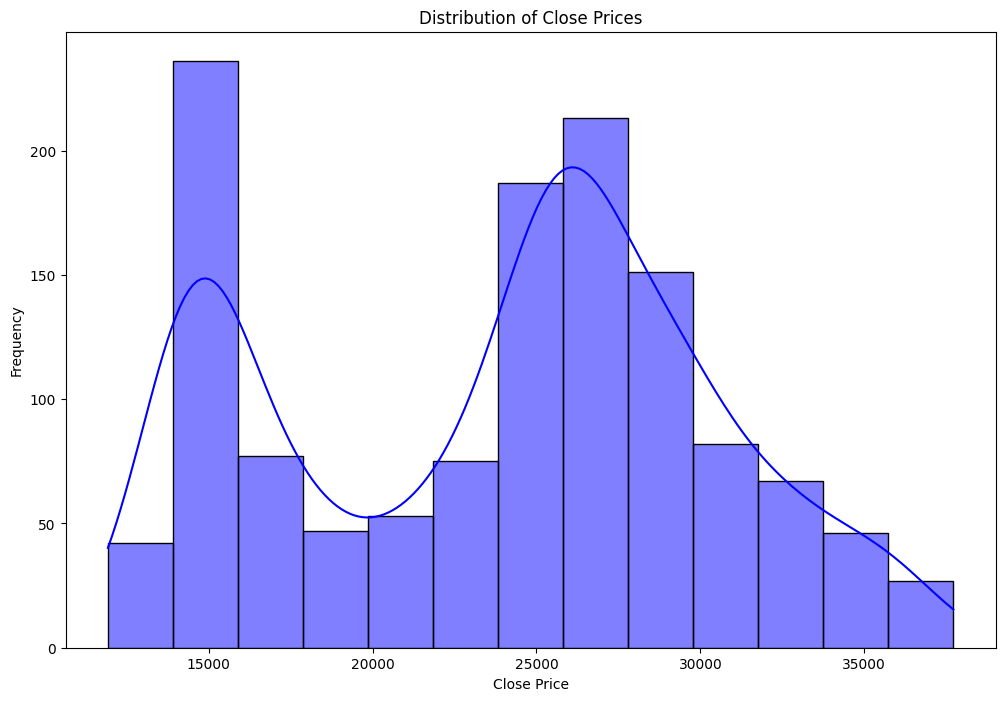

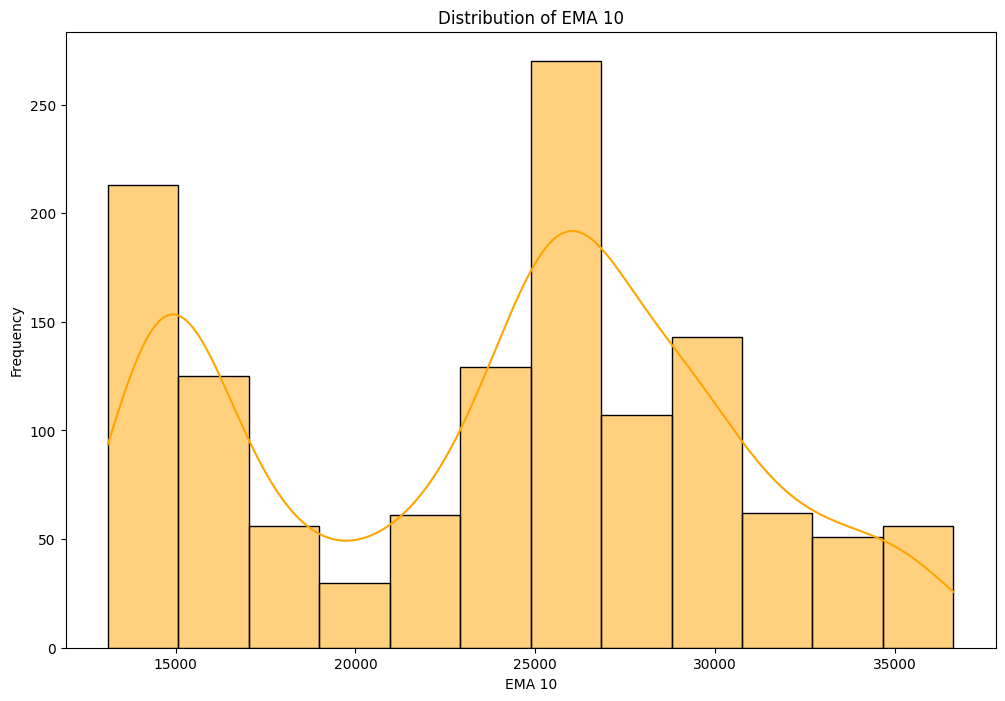

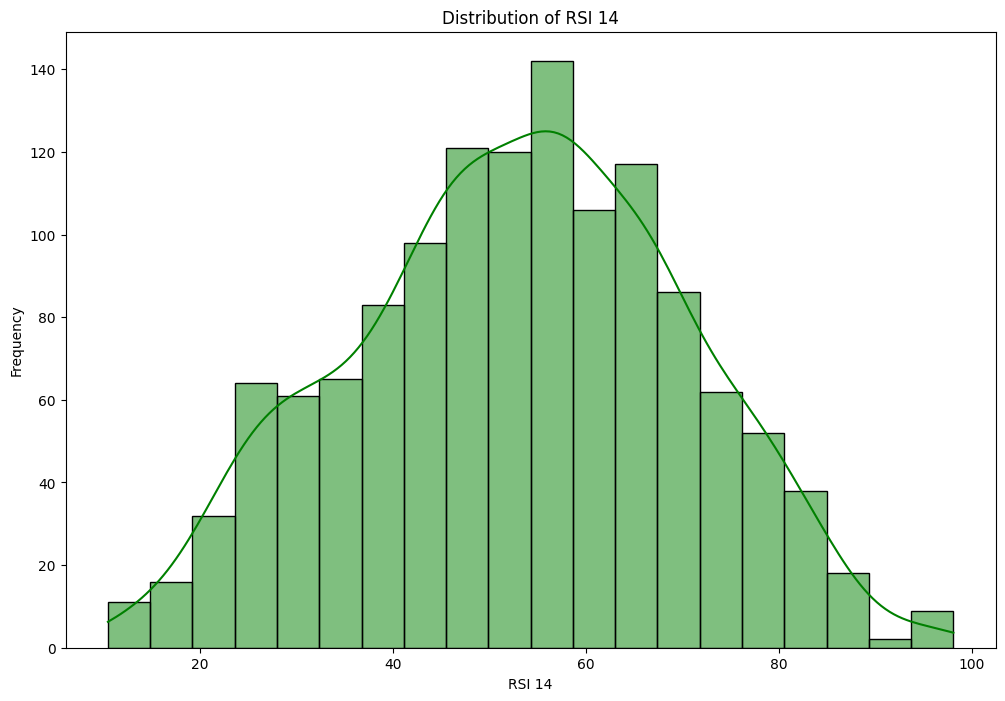

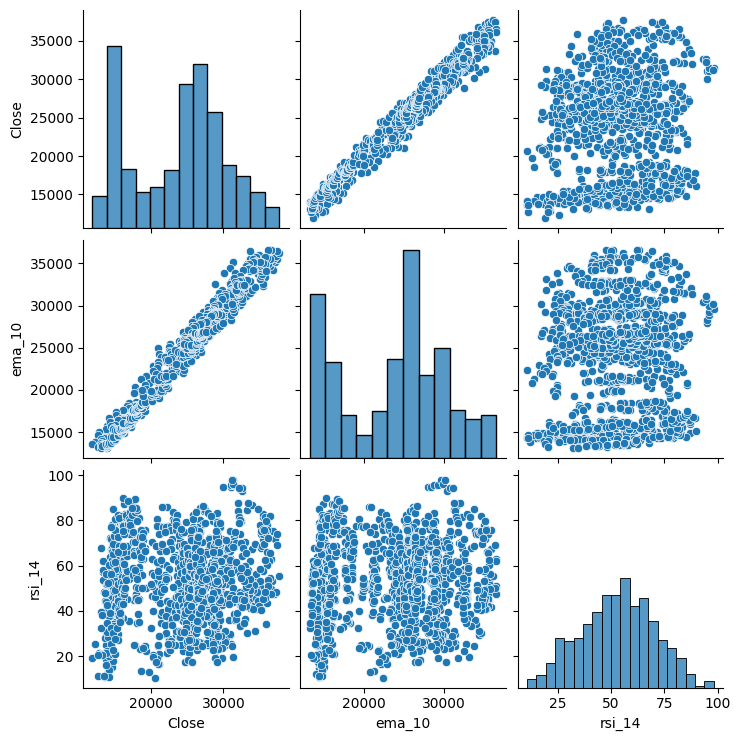

In [2]:
# Descriptive statistics for original 'Close', 'ema_10', and 'rsi_14'
descriptive_stats = data_with_features[['Close', 'ema_10', 'rsi_14']].describe()
print(descriptive_stats)

# Visualize the features separately
plt.figure(figsize=(12, 8))
sns.histplot(data_with_features['Close'], kde=True, color='blue')
plt.title('Distribution of Close Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 8))
sns.histplot(data_with_features['ema_10'], kde=True, color='orange')
plt.title('Distribution of EMA 10')
plt.xlabel('EMA 10')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 8))
sns.histplot(data_with_features['rsi_14'], kde=True, color='green')
plt.title('Distribution of RSI 14')
plt.xlabel('RSI 14')
plt.ylabel('Frequency')
plt.show()

# Pairplot for EMA and RSI
sns.pairplot(data_with_features[['Close', 'ema_10', 'rsi_14']])
plt.show()

In [3]:
# Train the Gradient Boosting Regressor
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [4]:
# Predict on the test set
y_pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
# Calculating test metrics
mape_test = mean_absolute_percentage_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
msle_test = mean_squared_log_error(y_test, y_pred)

# Print result
print('---------TEST----------')
print("MAPE:", round(mape_test, 3))
print("MAE:", round(mae_test, 3))
print("RMSE:", round(rmse_test, 3))
print("MSLE:", round(msle_test, 3))
print('-------------------')



---------TEST----------
MAPE: 0.016
MAE: 441.555
RMSE: 615.558
MSLE: 0.0
-------------------


In [5]:
# Forecasting function
def forecast(model, recent_data, lags, steps):
    forecasted = []
    input_data = recent_data.copy()
    for _ in range(steps):
        lag_features = input_data[-lags:]
        ema_10 = calculate_ema(pd.DataFrame({'Close': input_data[-11:]}), 10).iloc[-1]  # Calculate EMA for last 10 days
        rsi_14 = calculate_rsi(pd.DataFrame({'Close': input_data[-15:]}), 14).iloc[-1]  # Calculate RSI for last 14 days
        input_features = np.concatenate((lag_features, [ema_10, rsi_14])).reshape(1, -1)
        if np.isnan(input_features).any():
            input_features = np.nan_to_num(input_features)
        pred = model.predict(input_features)[0]
        forecasted.append(pred)
        input_data = np.append(input_data, pred)
    return forecasted

# For forecasting, we will use the last available data
recent_data = np.concatenate([X.iloc[-1].values[:-2], [y.iloc[-1]]])  # Exclude EMA and RSI from recent_data

# Forecast 30, 60, and 90 days
forecast_30_days = forecast(model, recent_data, lags, 30)
forecast_60_days = forecast(model, recent_data, lags, 60)
forecast_90_days = forecast(model, recent_data, lags, 90)


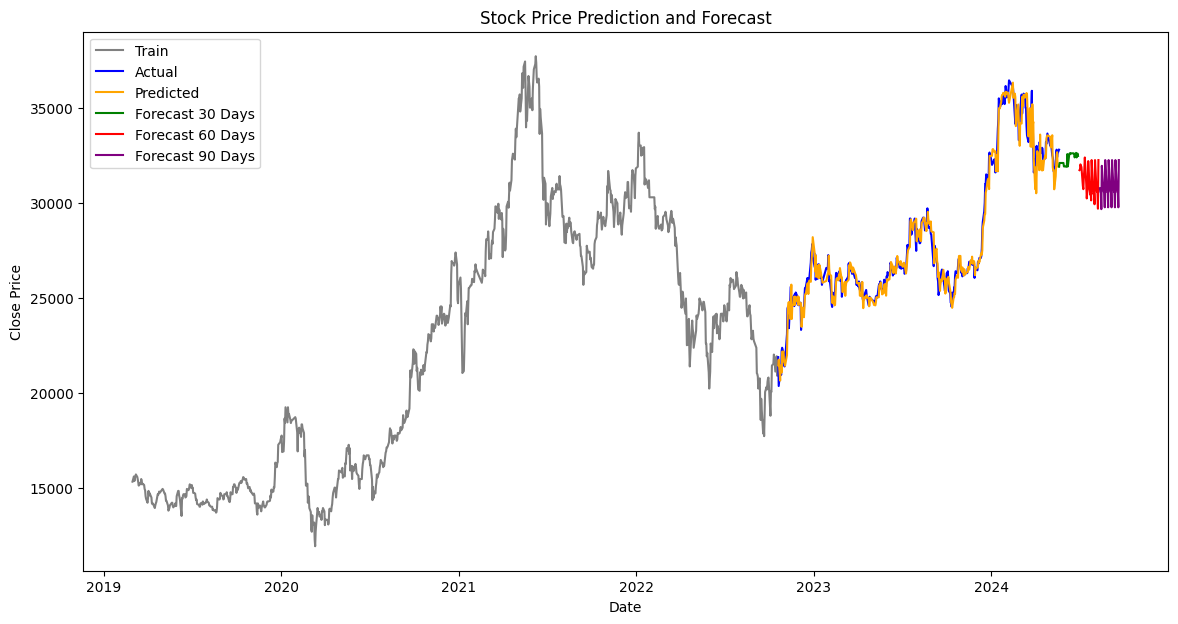

In [8]:
# Forecast dates starting right after the test set
forecast_start_date = data.index[len(y_train) + len(y_test) - 1]
forecast_dates_90 = pd.date_range(start=forecast_start_date, periods=90, freq='B')

# Plot the actual vs predicted values and the 90-day forecast split into three parts
plt.figure(figsize=(14, 7))

# Plot the training data
plt.plot(data.index[:len(y_train)], y_train, label='Train', color='gray')

# Plot the test data and predictions
plt.plot(data.index[len(y_train):len(y_train) + len(y_test)], y_test, label='Actual', color='blue')
plt.plot(data.index[len(y_train):len(y_train) + len(y_test)], y_pred, label='Predicted', color='orange')

# Split the 90-day forecast into three parts: 30 days, 60 days, and 90 days
forecast_60_days_final = forecast_60_days[30:60]
forecast_90_days_final = forecast_90_days[60:]

# Plot the forecasts
plt.plot(forecast_dates_90[:30], forecast_30_days, label='Forecast 30 Days', color='green')
plt.plot(forecast_dates_90[30:60], forecast_60_days_final, label='Forecast 60 Days', color='red')
plt.plot(forecast_dates_90[60:], forecast_90_days_final, label='Forecast 90 Days', color='purple')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Prediction and Forecast')
plt.legend()
plt.show()
